In [33]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jan 22 12:25:50 2023

@author: Can Aksan

"""
from matplotlib import pyplot as plt


class CoxRossRubinstein():
    
    def __init__(self, r, u, d, S0, K, T, X, type = "european"):
        """
        Parameters
        ----------
        r : float
            risikoloser Zins.
        u : float (groesser 1) 
            up faktor.
        d : float (kleiner 1, groesser 0)
            down faktor.
        S0 : float
            Wert der Aktie zum Zeitpunkt 0.
        K : float
            Ausuebungspreis.
        T : float
            Faelligkeit.
        X : function
            Auszahlungsfunktion eines Derivates.
        -------
        """
        self.type = type
        self.r = r
        self.u = u
        self.d = d
        self.S0 = S0
        self.K = K
        self.T = T
        self.X = X
        self.tree = {(0,0) : self.S0}   #Wurzel des Baumes.
        self.q = (1+r-d)/(u-d)
        
     
    #Methode ist als private deklariert
    def __forwardInduction(self):
        for i in range(1,self.T+1):
            for j in range(0,i):
                self.tree[(j,i)] = self.tree[(j,i-1)]*self.u
            self.tree[(i,i)] = self.tree[(i-1,i-1)]*self.d
            self.stocks = self.tree.copy() #Kopiert den Baum um einmal eine Baum mit den 
            #Aktienwerten und einmal einen Baum mit der Evolution des Derivatpreises zu erhalten
            self.OptimalStoppingTimes = self.tree.copy() #Kopiert den Baum um nachher die optimalen Stoppzeiten zu visualisieren
            
    def __getPrice(self,j, i):
        #Berechnet den Preis einer Option am aktuellen Knoten (j,i) 
        #mit der risikolosen Bewertungsformel
        return (self.tree[(j,i+1)]*self.q+self.tree[(j+1,i+1)]*(1-self.q))/(1+self.r)
            
    def __nodeValue(self,j, i):
        if self.type != "american":
            return self.__getPrice(j,i)
        else:
            S = self.stocks[(j,i)]
            intrinsicValue = self.X(S,self.K) #Wert den man durch ausüben erhalten würde   
            price = self.__getPrice(j,i) #Aktueller Wert der Option wenn man auf Ausübung verzichtet.
            
            if (intrinsicValue-price)>=10e-10: 
                self.OptimalStoppingTimes[(j,i)]=1
            else:
                self.OptimalStoppingTimes[(j,i)]=0
            
            return max(intrinsicValue,price)
        
    def __plotSnellEnvelope(self,titel):
        if self.type != "american":
            return
        
        for i in range(0,self.T):
            for j in range(0,i+1):
                x = [i+1,i,i+1]
                y_0 = self.tree[(j,i)]/(1+self.r)**i
                y_u = self.tree[(j,i+1)]/(1+self.r)**(i+1)
                y_d = self.tree[(j+1,i+1)]/(1+self.r)**(i+1)
                y = [y_u,y_0,y_d]
                plt.plot(x, y, '-o', color="black", markersize = 0)
                    
        plt.xlabel("Zeit")
        plt.ylabel("Preis")
        plt.title(titel)
        plt.show()
        
    
    def __backwardInduction(self):
        for j in range(0,self.T+1):
            self.tree[(j,self.T)] = self.X(self.stocks[(j,self.T)],self.K) #Auszahlungen im letzten Zeitschritt
            self.OptimalStoppingTimes[(j,self.T)]=1
            
        #Maximum von Auszahlung und Preis an den Knoten vor T
        for i in range(self.T-1,-1,-1):
            for j in range(0,i+1):
                self.tree[(j,i)] = self.__nodeValue(j, i)
    
    def __plotTree(self,tree,titel):
        #Methode Plottet ein Baumgitter
        #Knotten an denen ausgeübt werden sollte werden rot markiert
        if self.type == "american":
            for j in range(0,self.T+1):
                plt.scatter([self.T],[tree[(j,self.T)]], color = "red", s = 25)
                if j==0:
                    plt.legend(["Optimale Ausübungszeiten"])
        
        for i in range(0,self.T):
            for j in range(0,i+1):
                x = [i+1,i,i+1]
                y_0 = tree[(j,i)]
                y_u = tree[(j,i+1)]
                y_d = tree[(j+1,i+1)]
                y = [y_u,y_0,y_d]
                
                #Die If-Statements, die self.type == "american" abfragen, markieren die Knoten rot in denen es optimal ist eine amerikanische Option auszuüben
                if self.type == "american" and self.OptimalStoppingTimes[(j,i)]==1:
                    plt.scatter([i],[y_0], color = "red", s = 25)
            
                plt.plot(x, y, '-o', color="black", markersize = 0)
                    
        plt.xlabel("Zeit")
        plt.ylabel("Preis")
        plt.title(titel)
        plt.show()
    
    def plotTree(self,titel,stock=False):
        if stock == True:
            self.__plotTree(self.stocks, titel+"\n T="+str(self.T)+", "+"r="+str(self.r)+", "+" K=" 
                      + " $S_0=$"+str(S0)+", u="+str(self.u)+", "+ "d="+str(self.d)+", "+" q="+str(round(self.q,2)))
        else: 
            self.__plotTree(self.tree, titel+"\n T="+str(self.T)+", "+"r="+str(self.r)+", "+" K="+str(self.K)+"," 
                      + " $S_0=$"+str(S0)+", u="+str(self.u)+", "+ "d="+str(self.d)+", "+" q="+str(round(self.q,2)))
            self.__plotSnellEnvelope("Snell Einhüllende"+"\n T="+str(self.T)+", "+"r="+str(self.r)+", "+" K="+str(self.K)+"," 
                      + " $S_0=$"+str(S0)+", u="+str(self.u)+", "+ "d="+str(self.d)+", "+" q="+str(round(self.q,2)))
        
                
    def printTree(self):
        self.__forwardInduction()
        self.__backwardInduction()
        #print(self.tree)
        print("Preis der Option", self.tree[(0,0)])
        


Im Folgenden werden die Preisverläufe der europäischen Optionen aus Aufgabe 3 blatt 12 graphisch veranschaulicht.

Europaeischer Call
Preis der Option 21.466179094665684


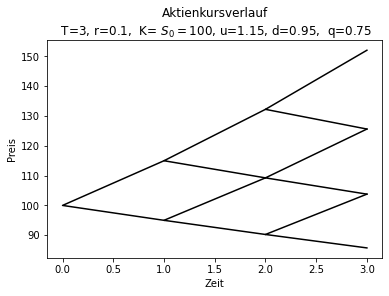

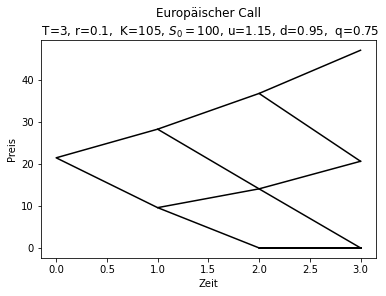

Europaeischer Put
Preis der Option 0.35423318933132725


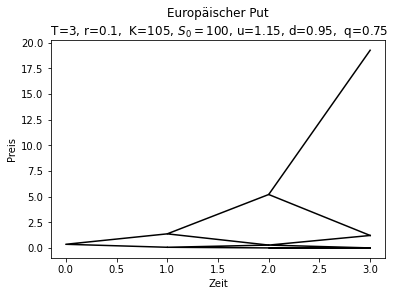

In [34]:
r=0.1
u=1.15
d=0.95
S0=100
K=105
T=3

#Aufgabe a), b) ,c) d)

def Call(S,K):
    return max(S-K,0)

def Put(S,K):
    return max(K-S,0)
    

#Europaeischer Call und Put:
CRR_EuropeanCall = CoxRossRubinstein(r, u, d, S0, K, T, X = Call)  
CRR_EuropeanPut = CoxRossRubinstein(r, u, d, S0, K, T, X = Put)  
#####################################################
print("Europaeischer Call")
CRR_EuropeanCall.printTree()
#Plottet einmal den Baum von "nur" den Aktienkursverläufen 
#(Plot kann erst ausgegeben werden wenn printTree zuvor aufgerufen wurde)
#########################################################
CRR_EuropeanCall.plotTree("Aktienkursverlauf",stock=True)
#########################################################
CRR_EuropeanCall.plotTree("Europäischer Call")
#####################################################
print("Europaeischer Put")
CRR_EuropeanPut.printTree()
CRR_EuropeanPut.plotTree("Europäischer Put")

In den nachfolgenden Abbildungen sind die Preisverläufe amerikanischer Optionen illustriert. Die Knoten, die rot markiert sind stellen die Zeitpunkte dar in denen es optimal ist auszuüben. Daher an diesen Knoten ist der Wert den man bei Ausübung erhalten würde größer als der Preis der Option. Hier sieht man auch beispielhaft, dass eine vorzeitige Ausübung sich bei einem amerikanischen Call auf eine dividendenlose Aktie nicht lohnt.

Amerikanischer Call
Preis der Option 21.466179094665684


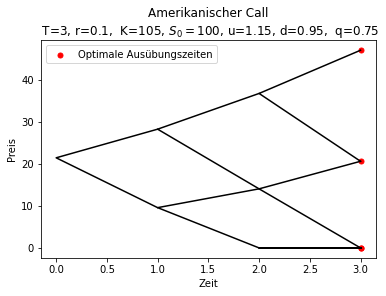

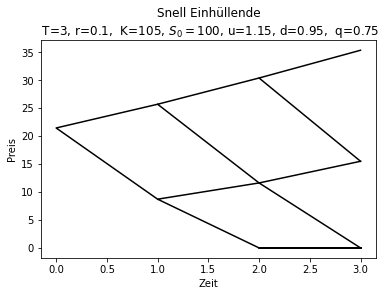

Amerikanischer Put
Preis der Option 5


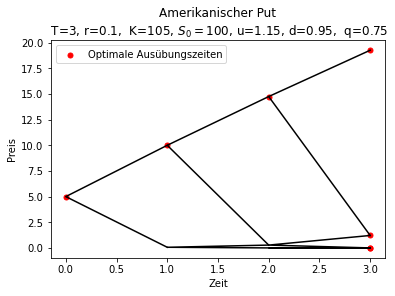

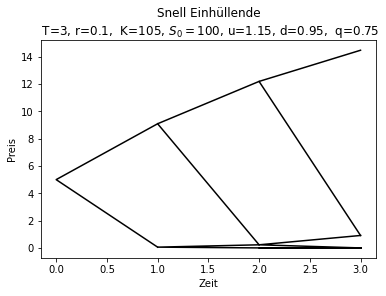

In [35]:
#American Call und Put:
CRR_AmericanCall = CoxRossRubinstein(r, u, d, S0, K, T, X = Call, type = "american")  
CRR_AmericanPut = CoxRossRubinstein(r, u, d, S0, K, T, X = Put, type = "american")  
##########################################################
print("Amerikanischer Call")
CRR_AmericanCall.printTree()
CRR_AmericanCall.plotTree("Amerikanischer Call")
##########################################################
print("Amerikanischer Put")
CRR_AmericanPut.printTree()
CRR_AmericanPut.plotTree("Amerikanischer Put")

Beispiele für $r=0.01$, $u=\exp\left(\sigma\sqrt{1/T}\right)$, $d=1/u$, $S0=100$, $K=100$, $T=30$, $\sigma=20 \%$

True
True
Europaeischer Call
Preis der Option 25.808778110060157


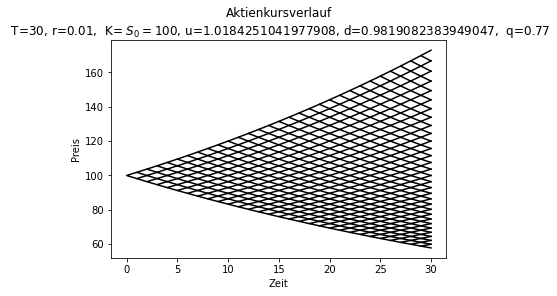

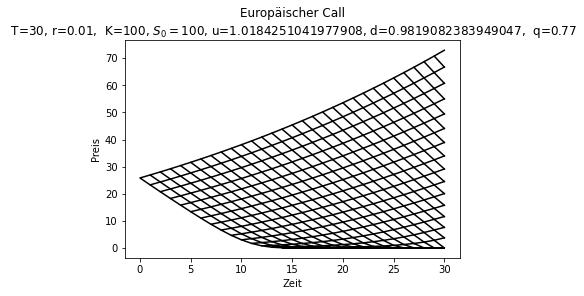

Europaeischer Put
Preis der Option 0.0010698887725746691


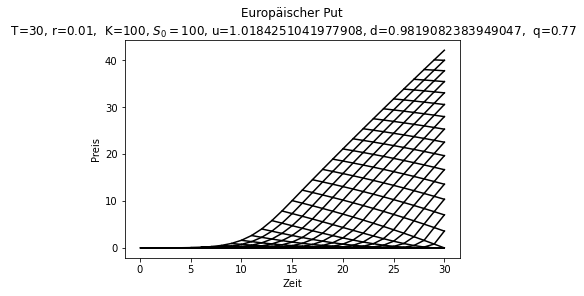

In [36]:
import numpy as np

r=0.01
sigma = 0.1
T=30
u=np.exp(sigma*np.sqrt(1/T))
d=1/u
S0=100
K=100

#Kurze überprüfung nach Arbitragefreiheit und Vollständigkeit
print(1+r<u)
print(1+r>d)

#Europaeischer Call und Put:
CRR_EuropeanCall = CoxRossRubinstein(r, u, d, S0, K, T, X = Call)  
CRR_EuropeanPut = CoxRossRubinstein(r, u, d, S0, K, T, X = Put)  
#####################################################
print("Europaeischer Call")
CRR_EuropeanCall.printTree()
#Plottet einmal den Baum von "nur" den Aktienkursverläufen 
#(Plot kann erst ausgegeben werden wenn printTree zuvor aufgerufen wurde)
#########################################################
CRR_EuropeanCall.plotTree("Aktienkursverlauf",stock=True)
#########################################################
CRR_EuropeanCall.plotTree("Europäischer Call")
#####################################################
print("Europaeischer Put")
CRR_EuropeanPut.printTree()
CRR_EuropeanPut.plotTree("Europäischer Put")

Amerikanischer Call
Preis der Option 25.808778110060157


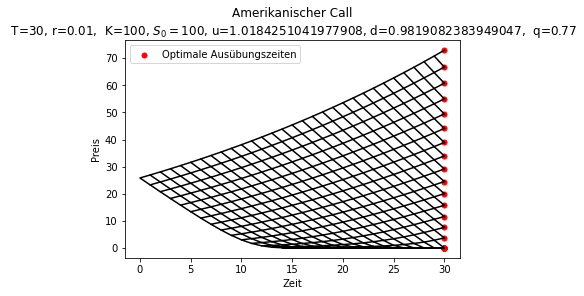

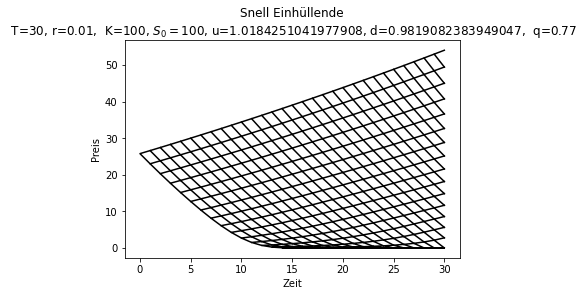

Amerikanischer Put
Preis der Option 0.5327350980363367


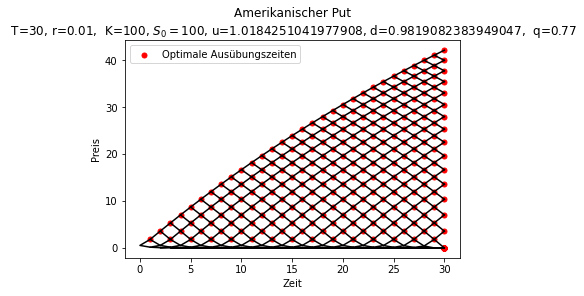

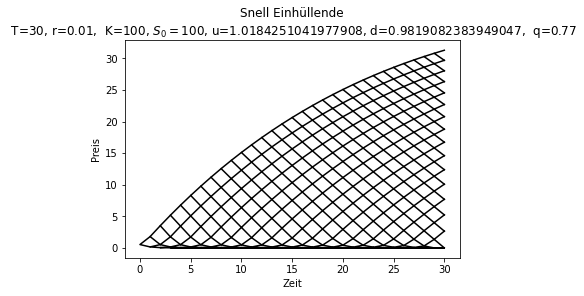

In [37]:
#American Call und Put:
CRR_AmericanCall = CoxRossRubinstein(r, u, d, S0, K, T, X = Call, type = "american")  
CRR_AmericanPut = CoxRossRubinstein(r, u, d, S0, K, T, X = Put, type = "american")  
##########################################################
print("Amerikanischer Call")
CRR_AmericanCall.printTree()
CRR_AmericanCall.plotTree("Amerikanischer Call")
##########################################################
print("Amerikanischer Put")
CRR_AmericanPut.printTree()
CRR_AmericanPut.plotTree("Amerikanischer Put")